In [1]:
!pip install -q wordcloud
!pip install -q pytorch-pretrained-bert pytorch-nlp

In [2]:
import pandas as pd

In [ ]:
df = pd.read_csv("/content/formatted_Amazon_Bestsellers_ALL_Reviews_2024-03-07_06-01.csv")
df

## Preprocessing
- Partition the ratings to 3 classes only
- Preprocessing text techniques: duplicate removal, lemmatization, stemming, uncasing, stopword removal, etc.
- Train/Test Split
- Some data visualization

### Drop duplicates

In [4]:
len(df)

23611

In [5]:
df.drop_duplicates(subset=['content'],inplace=True)

In [6]:
len(df)

5804

###  Partition the ratings to 3 classes only

In [7]:
def partition(x):
    if x < 3:
        return 2
    elif x < 5:
        return 0
    else:
        return 1

actualScore = df['rating']
class_ = actualScore.map(partition)
df['ratings_class'] = class_
df.ratings_class.value_counts()

1    4509
0     897
2     398
Name: ratings_class, dtype: int64

### Data Visualization

In [8]:
df.country.value_counts()

United States     1611
Singapore         1387
Canada             475
Mexico             402
Japan              368
United Kingdom     335
Australia          286
Germany            182
Spain              144
France             140
Italy              138
India              124
Brazil              95
Belgium             40
Sweden              33
Netherlands         29
Poland              15
Name: country, dtype: int64

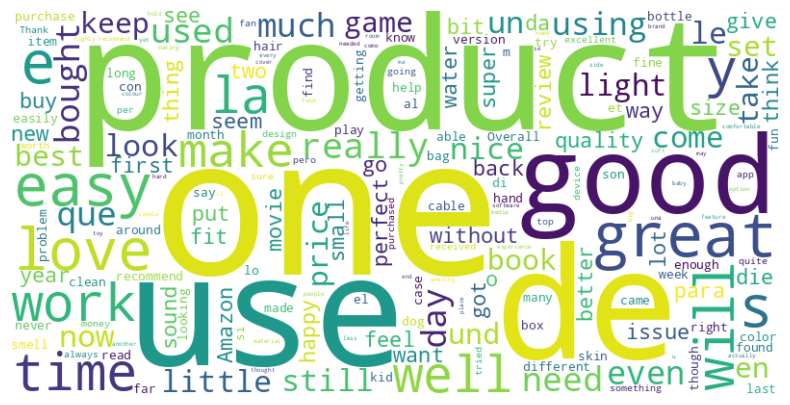

In [9]:
import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt

df['content'] = df['content'].astype(str)
text = ' '.join(df['content'])
wordcloud = WordCloud(width=800, height=400, background_color ='white').generate(text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

## Run simple models

In [10]:
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from pytorch_pretrained_bert import BertTokenizer, BertConfig
from pytorch_pretrained_bert import BertAdam, BertForSequenceClassification
from tqdm import tqdm, trange
import pandas as pd
import io
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [11]:
from sklearn.model_selection import train_test_split

# Create sentence and label lists
sentences = df.content.values

# We need to add special tokens at the beginning and end of each sentence for BERT to work properly
sentences = ["[CLS] " + str(sentence) + " [SEP]" for sentence in sentences]
labels = df.ratings_class.values

In [12]:
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased', do_lower_case=True)

tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]
print ("Tokenize the first sentence:")
print (tokenized_texts[0])

Tokenize the first sentence:
['[CLS]', 'Works', 'well', '.', 'Easy', 'application', '.', '[SEP]']


In [13]:
MAX_LEN = 128

In [ ]:
# Pad our input tokens
input_ids = pad_sequences([tokenizer.convert_tokens_to_ids(txt) for txt in tokenized_texts],
                          maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

In [ ]:
# Use the BERT tokenizer to convert the tokens to their index numbers in the BERT vocabulary
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]

In [16]:
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

In [17]:
# Create attention masks
attention_masks = []

# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
  seq_mask = [float(i>0) for i in seq]
  attention_masks.append(seq_mask)

In [18]:
# Use train_test_split to split our data into train and validation sets for training

train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels,
                                                            random_state=2018, test_size=0.1)
train_masks, validation_masks, _, _ = train_test_split(attention_masks, input_ids,
                                             random_state=2018, test_size=0.1)

In [19]:
train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)
train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)
train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

In [20]:
# Select a batch size for training. For fine-tuning BERT on a specific task, the authors recommend a batch size of 16 or 32
batch_size = 32

# Create an iterator of our data with torch DataLoader. This helps save on memory during training because, unlike a for loop,
# with an iterator the entire dataset does not need to be loaded into memory

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)


In [21]:
model = BertForSequenceClassification.from_pretrained('bert-base-multilingual-cased', num_labels=3)

In [22]:

param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]



In [23]:
optimizer = BertAdam(optimizer_grouped_parameters,
                     lr=2e-5,
                     warmup=.1)

In [24]:
# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [ ]:
train_loss_set = []

# Number of training epochs (authors recommend between 2 and 4)
epochs = 4

# trange is a tqdm wrapper around the normal python range
for _ in trange(epochs, desc="Epoch"):


  # Training

  # Set our model to training mode (as opposed to evaluation mode)
  model.train()

  # Tracking variables
  tr_loss = 0
  nb_tr_examples, nb_tr_steps = 0, 0

  # Train the data for one epoch
  for step, batch in enumerate(train_dataloader):
    # Add batch to GPU
    batch = tuple(t for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # Clear out the gradients (by default they accumulate)
    optimizer.zero_grad()
    # Forward pass
    loss = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
    train_loss_set.append(loss.item())
    # Backward pass
    loss.backward()
    # Update parameters and take a step using the computed gradient
    optimizer.step()


    # Update tracking variables
    tr_loss += loss.item()
    nb_tr_examples += b_input_ids.size(0)
    nb_tr_steps += 1

  print("Train loss: {}".format(tr_loss/nb_tr_steps))


  # Validation

  # Put model in evaluation mode to evaluate loss on the validation set
  model.eval()

  # Tracking variables
  eval_loss, eval_accuracy = 0, 0
  nb_eval_steps, nb_eval_examples = 0, 0

  # Evaluate data for one epoch
  for batch in validation_dataloader:
    # Add batch to GPU
    batch = tuple(t for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # Telling the model not to compute or store gradients, saving memory and speeding up validation
    with torch.no_grad():
      # Forward pass, calculate logit predictions
      logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    tmp_eval_accuracy = flat_accuracy(logits, label_ids)

    eval_accuracy += tmp_eval_accuracy
    nb_eval_steps += 1

  print("Validation Accuracy: {}".format(eval_accuracy/nb_eval_steps))

Epoch:   0%|          | 0/4 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/pytorch_pretrained_bert/optimization.py:275: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at ../torch/csrc/utils/python_arg_parser.cpp:1630.)
  next_m.mul_(beta1).add_(1 - beta1, grad)
